In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import operator

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, normalize
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import TensorBoard
from timeit import default_timer as timer
import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

dataPath = 'CleanedTrafficData'
resultPath = 'results_keras_tensorflow'
if not os.path.exists(resultPath):
    print('result path {} created.'.format(resultPath))
    os.mkdir(resultPath)
    
dep_var = 'Label'
model_name = "init"

cat_names = ['Dst Port', 'Protocol']
cont_names = ['Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
              'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
              'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
              'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
              'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
              'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
              'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
              'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
              'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
              'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
              'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
              'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
              'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
              'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
              'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
              'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
              'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
              'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
              'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
              'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
              'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

optimizer='adam'
epochs=10
batch_size=10

seed = 7
np.random.seed(seed)
cvscores = []
print('optimizer: {} epochs: {} batch_size: {}'.format(optimizer, epochs, batch_size))

result path results_keras_tensorflow created.
optimizer: adam epochs: 10 batch_size: 10


총 샘플의 수 : 400000
0.0    200000
1.0    200000
Name: Label, dtype: int64


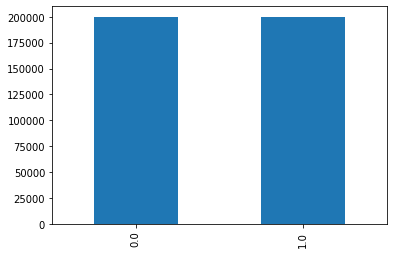

In [ ]:
def experiment(dataFile):
    #Creating data for analysis
    time_gen = int(time.time())
    global model_name
    global tensorboard
    model_name = f"{dataFile}_{time_gen}"
    #$ tensorboard --logdir=logs/
    tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))
    
    pickleDump = '{}.pickle'.format(dataFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(dataFile)
        # replace +ve and -ve infinity with NaN
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        df.fillna(0, inplace=True) # NaN -> 0
        df.to_pickle(pickleDump)
    return df

dataFile = 'dos_attack_100000.csv'
df = experiment(dataFile)
df = df.drop(['Unnamed: 0', 'Timestamp'], axis=1)
# df = df.drop(['Timestamp'], axis=1)
df.replace(to_replace=["DoS attacks-SlowHTTPTest", "DoS attacks-Hulk"],\
            value="DoS attacks", inplace=True)
 
# label name change
df = df.replace({'Label', 'Benign'}, 0) 
df = df.replace({'Label', 'DoS attacks'}, 1)

df = df.astype(float)
df.reset_index(inplace=True)

print('총 샘플의 수 :',len(df))
print(df['Label'].value_counts())
df['Label'].value_counts().plot(kind='bar')

In [ ]:
print(df.shape)
del df['index']
df

(400000, 80)


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,48746.0,6.0,4060517.0,5.0,3.0,935.0,369.0,935.0,0.0,187.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48460.0,6.0,4156177.0,5.0,4.0,935.0,360.0,935.0,0.0,187.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50738.0,6.0,4242728.0,5.0,3.0,935.0,288.0,935.0,0.0,187.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47388.0,6.0,4094253.0,5.0,3.0,935.0,303.0,935.0,0.0,187.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46134.0,6.0,4400842.0,5.0,3.0,935.0,350.0,935.0,0.0,187.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,80.0,6.0,2604.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
399996,80.0,6.0,6387.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
399997,80.0,6.0,43778.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
399998,80.0,6.0,113787.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Index(['Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts',
       'Subflow Bwd Pkts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Label'],
      dtype='object')


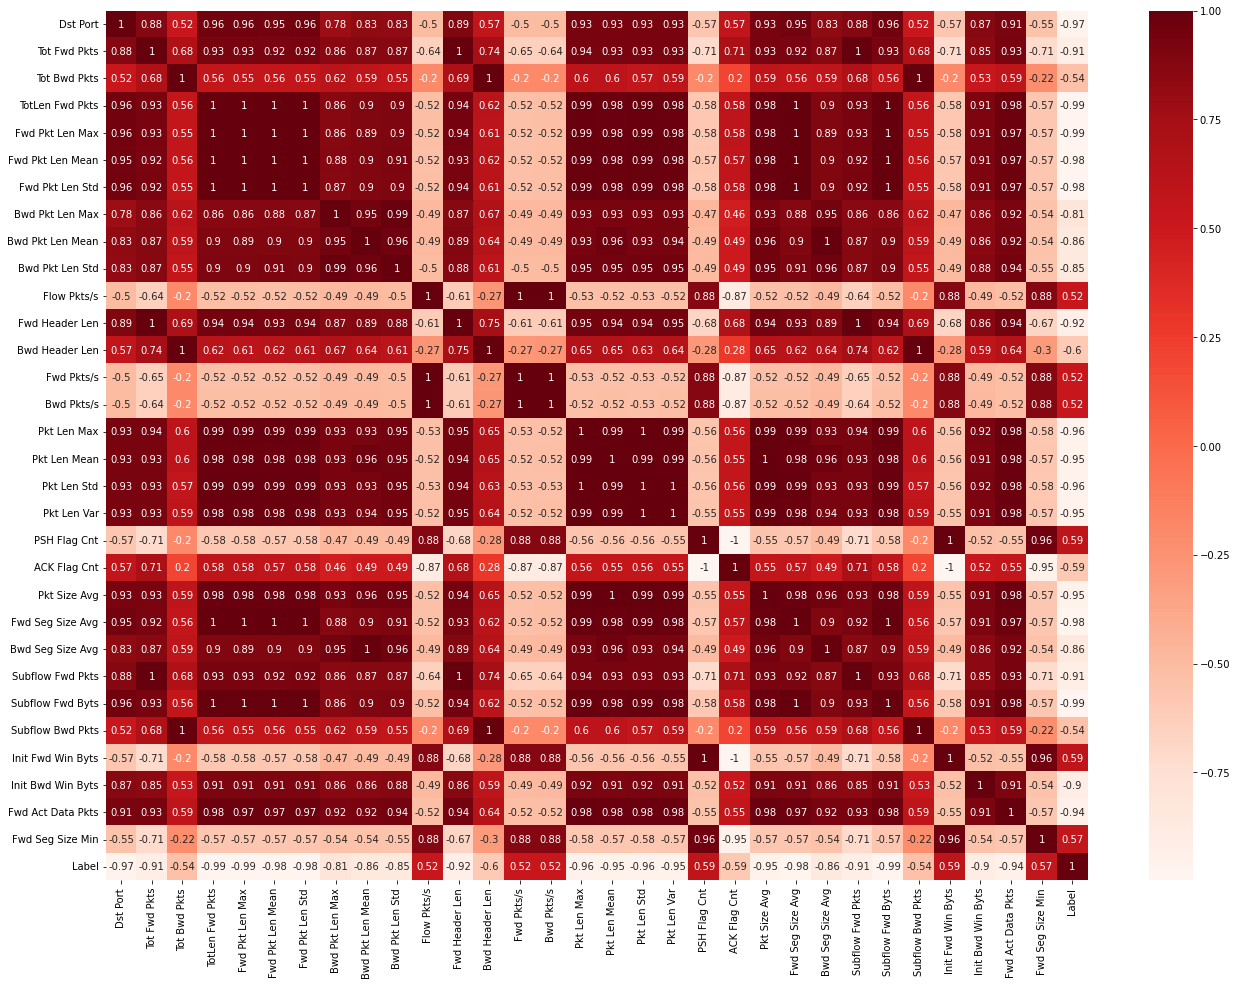

In [ ]:

cor = df.corr()
#Correlation with output variable
cor_target = abs(cor["Label"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features   
print(relevant_features.keys())

#Using Pearson Correlation
plt.figure(figsize=(22,16))
cor = df[relevant_features.keys()].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
importances = df.drop("Label", axis=1).apply(lambda x: x.corr(df.Label))
importances.fillna(0, inplace=True)
indices = np.argsort(importances)
print(importances[indices])

import scipy.stats as stats

# 피어슨 상관계수 검정

for i in range(0,len(df.columns)):
    k = True
    for j in  range(0,len(df.columns)):
        if i!=j:
            corr_1=np.abs(df[df.columns[i]].corr(df[df.columns[j]]))
            corr = stats.pearsonr(df[df.columns[i]], df[df.columns[j]])
            if corr[1] > 0.05:
                k = False 
    if k == True: 
        print(df.columns[i])

Fwd Pkt Len Max     -0.986263
TotLen Fwd Pkts     -0.985071
Subflow Fwd Byts    -0.985071
Fwd Pkt Len Std     -0.984005
Fwd Pkt Len Mean    -0.978851
                       ...   
Flow Pkts/s          0.517283
Fwd Pkts/s           0.518290
Fwd Seg Size Min     0.567858
Init Fwd Win Byts    0.588396
PSH Flag Cnt         0.588591
Length: 78, dtype: float64


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
CWE Flag Count
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Bwd Pkts/b Avg
Bwd Blk Rate Avg


78
Dst Port          7
Protocol          5
Flow Duration    63
Tot Fwd Pkts     10
Tot Bwd Pkts      9
                 ..
Active Min       16
Idle Mean        37
Idle Std         69
Idle Max         66
Idle Min         47
Length: 78, dtype: int64


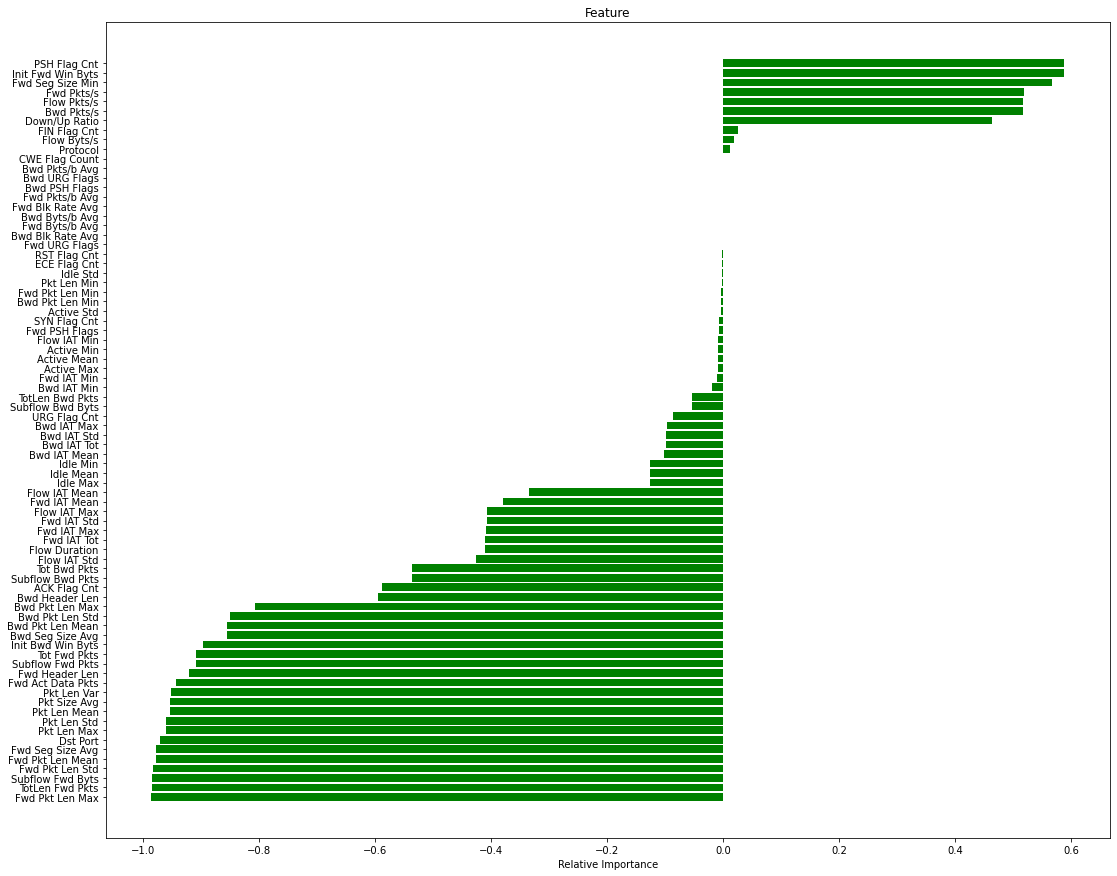

Dst Port
Tot Fwd Pkts
Tot Bwd Pkts
TotLen Fwd Pkts
Fwd Pkt Len Max
Fwd Pkt Len Mean
Fwd Pkt Len Std
Bwd Pkt Len Max
Bwd Pkt Len Mean
Bwd Pkt Len Std
Flow Pkts/s
Fwd Header Len
Bwd Header Len
Fwd Pkts/s
Bwd Pkts/s
Pkt Len Max
Pkt Len Mean
Pkt Len Std
Pkt Len Var
PSH Flag Cnt
ACK Flag Cnt
Pkt Size Avg
Fwd Seg Size Avg
Bwd Seg Size Avg
Subflow Fwd Pkts
Subflow Fwd Byts
Subflow Bwd Pkts
Init Fwd Win Byts
Init Bwd Win Byts
Fwd Act Data Pkts
Fwd Seg Size Min
Pos
Flow Pkts/s
Fwd Pkts/s
Bwd Pkts/s
PSH Flag Cnt
Init Fwd Win Byts
Fwd Seg Size Min
Neg
Dst Port
Tot Fwd Pkts
Tot Bwd Pkts
TotLen Fwd Pkts
Fwd Pkt Len Max
Fwd Pkt Len Mean
Fwd Pkt Len Std
Bwd Pkt Len Max
Bwd Pkt Len Mean
Bwd Pkt Len Std
Fwd Header Len
Bwd Header Len
Pkt Len Max
Pkt Len Mean
Pkt Len Std
Pkt Len Var
ACK Flag Cnt
Pkt Size Avg
Fwd Seg Size Avg
Bwd Seg Size Avg
Subflow Fwd Pkts
Subflow Fwd Byts
Subflow Bwd Pkts
Init Bwd Win Byts
Fwd Act Data Pkts


In [ ]:

names = ['Dst Port','Protocol','Flow Duration', 'Tot Fwd Pkts',
              'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
              'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
              'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
              'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
              'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
              'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
              'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
              'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
              'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
              'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
              'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
              'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
              'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
              'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
              'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
              'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
              'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
              'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
              'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
              'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']
print(len(names))
plt.figure(figsize=(18, 15))
plt.title('Feature')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
print(indices)
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

pos = [] 
neg = [] 
filtered_names = [] 
for i in range(0, len(indices)):
    if np.abs(importances[i])>0.5:
        print(names[i])
        filtered_names.append(names[i])
    
    if importances[i] > 0.5: 
        pos.append(names[i])
    elif importances[i] < -0.5:
        neg.append(names[i])

print("Pos")
# filtered_names.append('Label')
for i in pos:
  print(i)
print("Neg")
# filtered_names.append('Label')
for i in neg:
  print(i)

In [ ]:
def baseline_model(inputDim=-1, out_shape=(-1,)):
    global model_name
    model = Sequential()

    if inputDim > 0 and out_shape[1] > 0:
        model.add(Dense(inputDim, activation='relu', input_shape=(inputDim,)))
        print(f"out_shape[1]:{out_shape[1]}")
        model.add(Dense(128, activation='sigmoid'))
        model.add(Dropout(0.2))
        
        model.add(Dense(out_shape[1], activation='softmax')) #This is the output layer
        
        if out_shape[1] > 2:
            print('Categorical Cross-Entropy Loss Function')
            model_name += "_categorical"
            model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        else:
            model_name += "_binary"
            print('Binary Cross-Entropy Loss Function')
            model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return model

def load_model_csv(_model_name):
    #Change to your own path
    model = load_model('results_keras_tensorflow/models/{}'.format(_model_name))
    return model

def experiment(data, optimizer='adam', epochs=10, batch_size=10):
    
    data_x = data[:-1]
    data_y = data.pop('Label')
    encoder = LabelEncoder()
    encoder.fit(data_y)
    data_y = encoder.transform(data_y)
    dummy_y = to_categorical(data_y)

    data_x = normalize(data.values)

    #define 5-fold cross validation test harness
    inputDim = len(data_x[0])

    print('input= ', data_x.shape[0],'inputdim = ', data_x.shape[1])
    num=0
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
    start = timer()

    for train_index, test_index in sss.split(X=np.zeros(data_x.shape[0]), y=dummy_y):
        X_train, X_test = data_x[train_index], data_x[test_index]
        y_train, y_test = dummy_y[train_index], dummy_y[test_index]

        #create model
        model = baseline_model(inputDim, y_train.shape)
    
        #train
        model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, \
                  verbose=2, callbacks=[tensorboard], validation_data=(X_test, y_test))

        #save model
        model.save('ids_dos_attack.h5')

        num+=1

    elapsed = timer() - start
    pred = model.predict(X_test) 
    print("Pred:", pred) 

    scores = model.evaluate(X_test, y_test, verbose=1)
    print(model.metrics_names)
    acc, loss = scores[1]*100, scores[0]*100
    print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))
    
    
    resultFile = os.path.join(resultPath, dataFile)
    with open('{}.result'.format(resultFile), 'a') as fout:
        fout.write('{} results...'.format(model_name))
        fout.write('\taccuracy: {:.2f} loss: {:.2f}'.format(acc, loss))
        fout.write('\telapsed time: {:.2f} sec\n'.format(elapsed))

if __name__ == "__main__":
    experiment(df.copy(deep=True))


input=  400000 inputdim =  78
out_shape[1]:2
Binary Cross-Entropy Loss Function
Epoch 1/10
32000/32000 - 73s - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.0097 - val_accuracy: 0.9963 - 73s/epoch - 2ms/step
Epoch 2/10
32000/32000 - 64s - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.0048 - val_accuracy: 0.9983 - 64s/epoch - 2ms/step
Epoch 3/10
32000/32000 - 64s - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0032 - val_accuracy: 0.9987 - 64s/epoch - 2ms/step
Epoch 4/10
32000/32000 - 62s - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.0028 - val_accuracy: 0.9990 - 62s/epoch - 2ms/step
Epoch 5/10
32000/32000 - 64s - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.0027 - val_accuracy: 0.9989 - 64s/epoch - 2ms/step
Epoch 6/10
32000/32000 - 63s - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9992 - 63s/epoch - 2ms/step
Epoch 7/10
32000/32000 - 61s - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.0020 - val_accuracy: 0.9990 - 61s/epoch - 2ms/step
Epoch 8/10
32000/32000 -

Train
(24000, 23)
(24000,)
Test
(6000, 23)
(6000,)
0.9995


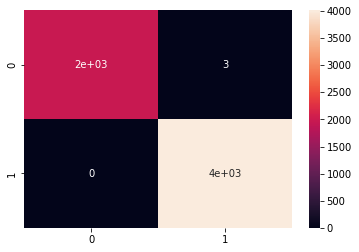

In [ ]:
from sklearn.metrics import confusion_matrix

data = df.copy(deep=True)
X = data[filtered_names] 
y = data.pop('Label')

X = normalize(X.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Train")
print(X_train.shape)
print(y_train.shape)

print("Test")
print(X_test.shape)
print(y_test.shape)

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = clf.score(X_test, y_test)
print(acc)

# Separate out data
cf_matrix = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)